## Adatok elemzése predikciós módszerekkel, és klaszterező algoritmusokkal

### Szétválasztható-e, hogy melyik bérlés milyen céllal történt?
Mint korábban kiferült, a bérlések jelentős száma lokálisan történik.
Ezek alapján felmerül a kérdés, hogy szétválasztható-e az adat olyan csoportokra, amik ebben eltérnek.

### Milyen trendek figyelhetőek meg az adatokon?
Az adattisztítás alapján úgy tűnik, hogy éjszaka is van forgalom. Illetve szinte biztos, hogy egy napi hullámzs mindenképpen megfigyelhető a trendeken.
Ezeket ki lehet számolni a Prophet segítségével. Egy esetleges predikciós algoritmus kialakításához ezek jó alapot tudnak biztosítnai.


In [1]:
import pandas as pd
import numpy as np


In [2]:
gdf = pd.read_parquet("full_data_cleaned.parquet")
wdf = pd.read_parquet("weather_cleaned.parquet")

print("original row count: ",gdf.shape[0])
df = gdf[gdf["Duration"]>0].sample(10**7)

original row count:  80457155


In [3]:
df["Date"] = df["Start Date"].apply(lambda x: x.date())

In [4]:

pred_df_prior = df.merge(wdf,how='left',left_on=pd.DatetimeIndex(df['Date']),right_index=True)
pred_df = pred_df_prior.copy()

In [5]:
#massacare
pred_df['Start hour float'] = pred_df['Start hour'].apply(lambda x: x.hour + x.minute/60.)
pred_df['End hour float'] = pred_df['End hour'].apply(lambda x: x.hour + x.minute/60.)

In [6]:
catlike_variables = ['Rental Id','Bike Id','Date','End Date','Start Date','EndStation Id','StartStation Id','StartStation Name','EndStation Name','Start hour','End hour']
pred_df.drop(columns=catlike_variables,inplace=True)


In [7]:
pred_df.head()

,Duration,Duration minute,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,Start hour float,End hour float
515098,360,6,21.7,13.1,29.9,0.0,0.0,112.0,12.1,0.0,1014.2,23.283333,23.383333
9676,1260,21,7.5,5.0,9.0,0.3,0.0,26.0,10.6,0.0,1025.0,21.766667,22.116667
159979,480,8,9.9,5.6,13.5,0.4,0.0,297.0,13.5,31.5,1014.6,5.633333,5.766667
222105,1980,33,-2.8,-3.7,-1.6,0.3,0.0,46.0,14.3,29.6,1007.3,18.700000,19.250000
206422,480,8,10.5,7.8,12.9,0.0,0.0,147.0,18.5,42.6,1003.3,10.183333,10.316667


In [8]:


pred_df.fillna(0,inplace=True)

In [9]:
from sklearn.cluster import MiniBatchKMeans


clusterer = MiniBatchKMeans(n_clusters=4,batch_size=1024*4)
data = pred_df.to_numpy()
res = clusterer.fit_transform(data)
pred_df["mBatch KMEANS"] = clusterer.labels_

#cool, now I have to visualize it :/

In [10]:
pre_prophet_df = df.groupby(['Date']).agg(**{'Rental Id_size': ('Rental Id', 'size'), 'Duration_sum': ('Duration', 'sum'),'Duration_avg': ('Duration', 'mean')}).reset_index()

C:\Users\Sztaki\AppData\Local\Temp\ipykernel_18832\1983004497.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prophet_df.rename(columns={'Date':'ds','Rental Id_size':'y'},inplace=True)
07:34:06 - cmdstanpy - INFO - Chain [1] start processing
07:34:06 - cmdstanpy - INFO - Chain [1] done processing


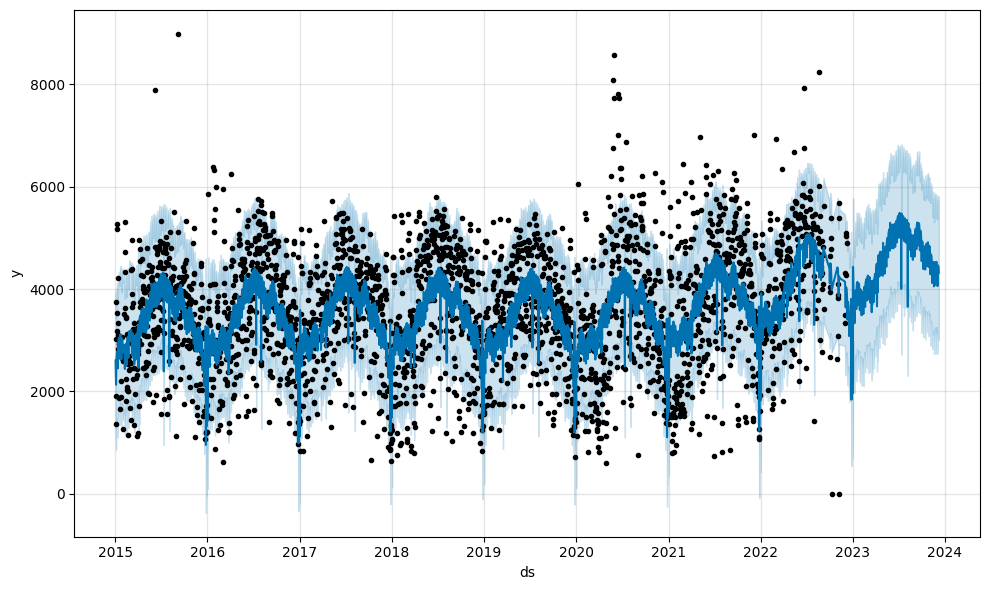

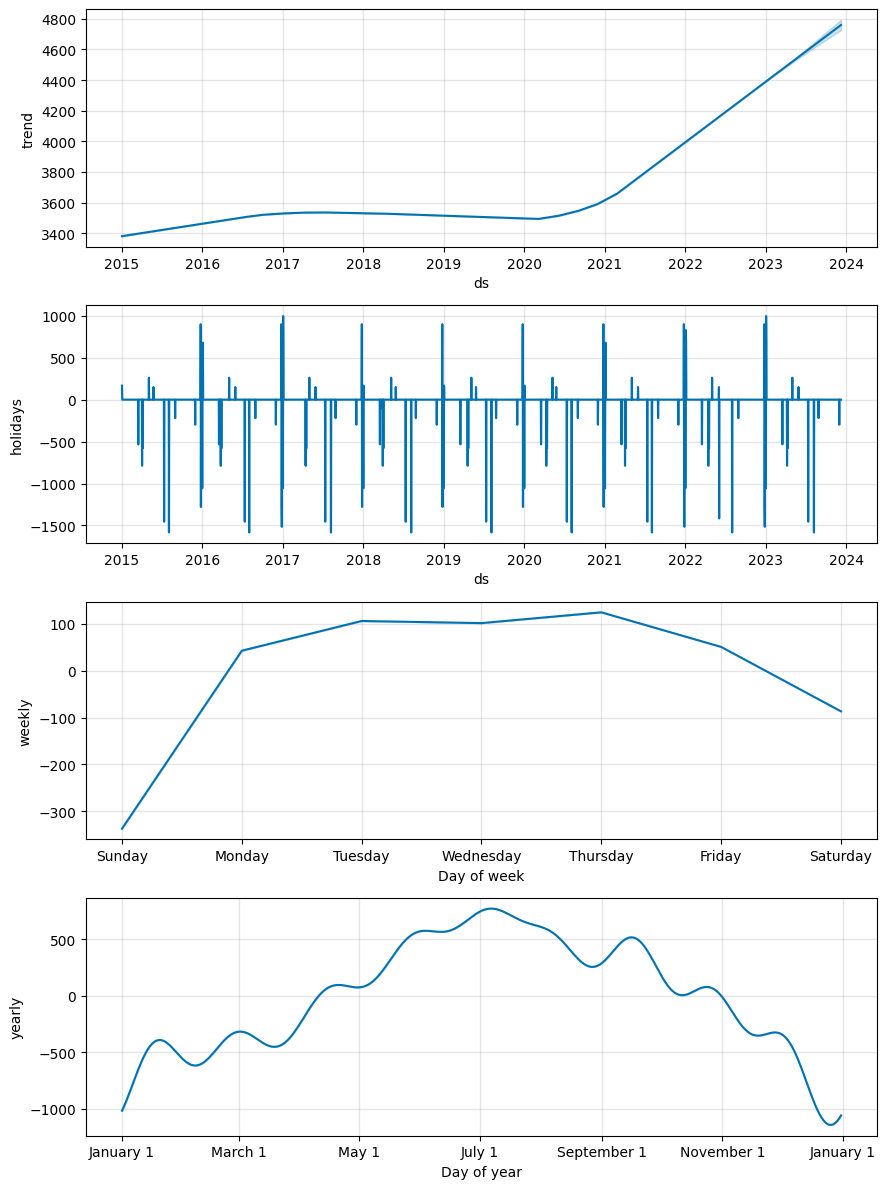

In [13]:
import pandas as pd
from prophet import Prophet

#daily rent estimation
prophet_df = pre_prophet_df[['Date','Rental Id_size']]
prophet_df.rename(columns={'Date':'ds','Rental Id_size':'y'},inplace=True)

m = Prophet()
m.add_country_holidays(country_name='UK')
m.fit(prophet_df)

future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)

fig1 = m.plot(forecast)
fig2 = m.plot_components(forecast)
